In [77]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [78]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])




In [79]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

import seaborn as sns
from causalgraphicalmodels import CausalGraphicalModel
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    conf_mult = 1
    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


# 1. Experiments that Y only influenced by observable covariates
## 1.1 Simulate a DGP

$y = \tau*T+\beta'*x+e$

In [81]:
tau = 2
corr = .4
conf=False
p = 3
p0 = 2 # number of covariates used in the DGP
flagX = 1
N = 1000
Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)

In [82]:
data = np.concatenate([Y,T,X],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'X1', 'X2','X3']
data.to_csv('data1.csv')
data

,Y,T,X1,X2,X3
0,-2.458472,0.0,0.136056,-0.718579,-0.142329
1,2.688750,0.0,-0.278547,0.738703,-0.438197
2,-0.152611,1.0,0.503769,-0.335222,-0.238310
3,9.109306,0.0,0.835343,1.218797,0.099300
4,4.177969,1.0,-0.024311,0.770475,-0.568915
...,...,...,...,...,...
995,-3.669524,1.0,-0.283320,-1.105547,-0.749364
996,-4.531516,1.0,-0.790099,-1.234910,-1.570918
997,7.059307,1.0,-0.331315,1.132293,1.390406
998,5.456651,1.0,0.329092,0.734249,-0.806568


## 1.2 Illustration with a DAG & examples in reality

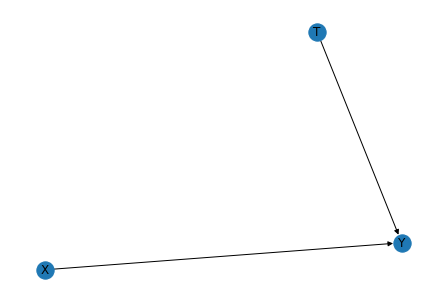

In [83]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='X')
G.add_edge('s2','s1')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()


Example in reality:  
Whether it is rainy will impact the price of umbrella. At the same time, umbrella price is also influenced by cost of labor, rent, raw material. But these costs will not impact the weather.  
So in this case, we can view whether it is rainy as T, umbrella price as Y, and the cost of labor, rent, raw material as covariates.

## 1.3 Monte Carlo Experiments

### 1.3.1 with covariates not controlled

In [84]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 190.26it/s]


In [85]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.09533010590639257, RMSE=2.1368824224599714, size=0.056
N=1000: bias=-0.005298092242764655, RMSE=0.6904547023087363, size=0.054


### 1.3.2 with covariates controlled

In [86]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 172.35it/s]


In [87]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0037875554709077284, RMSE=0.14074982729612873, size=0.049
N=1000: bias=0.0012144245404474595, RMSE=0.0444783100217157, size=0.049


Implications:   
Compared between different sample size, the RMSE with sample size = 1000 is smaller that with sample size = 100.  
Compared between controlling different variables, the RMSE with covariates controlled is smaller that with covariates not controlled.

# 2. Experiments with a confounder
## 2.1 Simulate a DGP

$y = \tau*T+0.5*Confounder+e$   

$T = 0.5*Confounder+u$

In [88]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1]) # confounder
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.5*C+err
    Tab = T+0.5*C

    return (Yab,Tab,C)

In [89]:
tau = 2
corr = .5
p = 3
Y,T,C = fn_generate_data_conf(tau,N,p,corr)

In [90]:
data = np.concatenate([Y,T,C],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'C']
data.to_csv('data2.csv')
data

,Y,T,C
0,0.017438,0.265971,0.531942
1,-0.696592,0.206178,0.412355
2,0.899459,0.938999,-0.122001
3,1.046762,-0.421429,-0.842859
4,3.292047,1.413525,0.827050
...,...,...,...
995,1.588787,0.602828,-0.794343
996,0.260652,-0.197528,-0.395055
997,3.457169,1.455411,0.910822
998,2.349967,1.231946,0.463892


## 2.2 Illustration with a DAP and example in reality

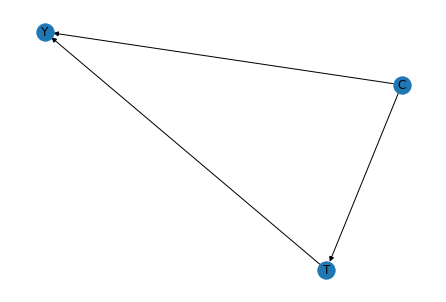

In [91]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='C')
G.add_edge('s2','s1')
G.add_edge('s3','s2')
G.add_edge('s3','s1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()


Example in reality:   
Major will impact the choice of career. At the same time, influenced by social norms, gender has inevitable impact on both major choice and career choice.   
Thus, we can view gender as the confounder C, major sa treatment T and career as outcome variable Y.

## 2.3 Monte carlo experiments
###  2.3.1 with a confounder not controlled

In [92]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 181.02it/s]


In [93]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.31468180558407655, RMSE=0.34917546327780946, size=0.687
N=1000: bias=-0.32054715422913027, RMSE=0.3348925250593416, size=0.992


### 2.3.2 with a confounder controlled

In [94]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 176.95it/s]


In [95]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.005897632906766186, RMSE=0.14662022538768665, size=0.065
N=1000: bias=0.0009438688544046696, RMSE=0.04534148232525973, size=0.058


Implications:  
Compared between different sample size, the RMSE with sample size = 1000 is smaller that with sample size = 100.  
Compared between controlling confounder or not, the RMSE with confounder controlled is much smaller that with confounder not controlled.

# 3. with selection bias in the DGP
## 3.1 Simulate a DGP

$s = 0.5*y+0.5*T+u$  
$y = 0.1*T+e$  
Here we let tau = 0.1 to examine how the weak relation will be observed with or without controlling the common effect.

In [96]:
def fn_generate_data_s(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Y = tau*T+err
    S = 0.5*T+0.5*Y+U

    return (Y,T,S)

In [97]:
tau = 0.1
corr = 0.5
p = 3
N = 1000
Y,T,S = fn_generate_data_s(tau,N,p,corr)

data = np.concatenate([Y,T,S],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'S']
data.to_csv('data3.csv')
data

,Y,T,S
0,1.326971,1.0,1.454665
1,0.785514,0.0,-1.497610
2,-1.524904,0.0,-1.186742
3,-0.263479,0.0,0.630706
4,0.350545,1.0,1.032168
...,...,...,...
995,1.462137,1.0,0.767270
996,1.351742,1.0,0.500098
997,-0.516818,1.0,2.363162
998,-0.122669,1.0,0.300008


## 3.2 Illustration with a DAG and example in reality

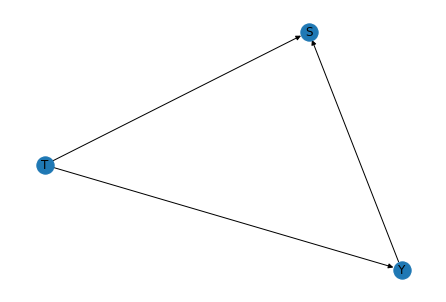

In [98]:
G = nx.DiGraph()
    
G.add_node('s1', desc='Y')
G.add_node('s2', desc='T')
G.add_node('s3', desc='S')
G.add_edge('s2','s1')
G.add_edge('s1','s3')
G.add_edge('s2','s3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos)
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()


Example in reality:  
There is a famous example about bombers in WWII. People are trying to figure out which part of the plane is most fragile and needed strenthening. The conclusion is they need to add more armor to the places where there was no damage. Because they were only able to analyze the bombers that returned. These bombers’ wounds showed where they could afford to be hit.  
So in this case, the treatment is damage at certain part. The outcome is whether the plane crashed. S refers to whether the plane came back.

## 3.3 Monte carlo experiments
### 3.3.1 with selection bias not controlled

In [99]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 192.69it/s]


In [100]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.012420448932937407, RMSE=0.20173592902534268, size=0.058
N=1000: bias=-0.003339542836592319, RMSE=0.06414490924105397, size=0.062


### 3.3.2 DGP with selection bias controlled

In [101]:
estDict = {}
R = 1000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Z = fn_generate_data_s(tau,N,p,corr)
        covars = np.concatenate([T,Z],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 1000/1000 [00:05<00:00, 173.27it/s]


In [102]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.22163994533221842, RMSE=0.26033543427265143, size=0.389
N=1000: bias=-0.21960230789338475, RMSE=0.223788397283721, size=1.0


Implications:  
Compared between different sample size, the RMSE with sample size = 1000 is smaller that with sample size = 100.  
Compared between controlling selection bias or not, the RMSE with selection bias controlled is larger that with selection bias not controlled.